In [2]:
from pymagnitude import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import enchant
from collections import Counter
import faiss
import re
def words(text): return re.findall(r'\w+', text.lower())
WORDS = Counter(words(open('big.txt').read()))
d = enchant.Dict("en_US")
from operator import itemgetter, attrgetter

In [3]:
def spelltest_top(tests , top_rank,show =False):
    import time
    start = time.clock()
    good, unknown = 0, 0
    n = len(tests)
    for right, wrong in tests:
        
        right = right.lower().replace('.','').replace(',','').replace('!','').replace('?','')
        
        wrong = wrong.lower().replace('.','').replace(',','').replace('!','').replace('?','')
        w_set = d.suggest(wrong)[:top_rank]
        w_set = [ se.lower() for se in w_set]
        if right in w_set:
            good+=1
        else:
            unknown += (right not in WORDS)
            if show:
                print('錯字是 : '+ wrong.replace(' ','') )
                print('正確答案是 : ' + right)
                print('錯誤建議 : ' , w_set )
                print('\n')
    dt = time.clock() - start
    print('{:.0%} of {} correct ({:.0%} unknown) at {:.0f} words per second '
              .format(good / n, n, unknown / n, n / dt))

In [4]:
def dameraulevenshtein(seq1, seq2):
    oneago = None
    thisrow = list(range(1, len(seq2) + 1)) + [0]
    for x in range(len(seq1)):
        twoago, oneago, thisrow = oneago, thisrow, [0] * len(seq2) + [x + 1]
        for y in range(len(seq2)):
            delcost = oneago[y] + 1
            addcost = thisrow[y - 1] + 1
            subcost = oneago[y - 1] + (seq1[x] != seq2[y])
            thisrow[y] = min(delcost, addcost, subcost)
            # This block deals with transpositions
            if (x > 0 and y > 0 and seq1[x] == seq2[y - 1]
                and seq1[x-1] == seq2[y] and seq1[x] != seq2[y]):
                thisrow[y] = min(thisrow[y], twoago[y - 2] + 1)
    return thisrow[len(seq2) - 1]
import difflib
def difflib_leven(str1, str2):
    leven_cost = 0
    s = difflib.SequenceMatcher(None, str1, str2)
    for tag, i1, i2, j1, j2 in s.get_opcodes():
       #print('{:7} a[{}: {}] --> b[{}: {}] {} --> {}'.format(tag, i1, i2, j1, j2, str1[i1: i2], str2[j1: j2]))
        if tag == 'replace':
            leven_cost += max(i2-i1, j2-j1)
        elif tag == 'insert':
            leven_cost += (j2-j1)
        elif tag == 'delete':
            leven_cost += (i2-i1)
    return leven_cost

## 抓Ef的錯字標籤的word並當作訓練資料

In [5]:
train_set = open('../NLP_Final/gec_data/spell_word_mistake.txt').readlines()
train_pair = []
count = 0 
for line in train_set:
    line  = line.replace('\n','')
    c , f = line.split(' ')[1] , line.split(' ')[0]
    if c==f:
        pass
    elif re.search('\d',c) or re.search('\d',f) :
        pass
    elif len(c)< 2 or len(f)<2:
        pass
    elif dameraulevenshtein(c , f) < 3:
        train_pair.append((c ,f))

In [6]:
print(len(train_pair))

719667


## 引入glove model : </br> Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download)

### glove 可以克服 oov </br>https://github.com/RaRe-Technologies/gensim/issues/1953 ex: hiiiiii

In [7]:
vectors = Magnitude("glove-crawl.magnitude")
len(vectors)

2196017

## 訓練Transformation Vector 719667個字

In [8]:
# 719667
spell_transform_eff = np.zeros((300,))
count = 0
for row in train_pair:
    spell_transform_eff += vectors.query(row[1]) - vectors.query(row[0])
    count+=1
spell_transform_eff /=count

In [11]:
np.save('tran_vec',spell_transform_eff)

In [12]:
sp = np.load('tran_vec.npy')

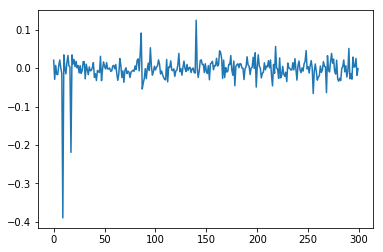

In [13]:
plt.plot(sp)

## V('king')-V('man') + V('woman') = V('queen')</br>V('catt') - V('cat') = transormation vector</br>V("catt") - transormation vector = V('cat')</br>V('spel') - transormation vector = V('spell')

In [245]:
correct_word = 'cat'
mispell = 'catt'
tran = vectors.query(mispell) - vectors.query(correct_word)
result = vectors.query(mispell) - tran

In [246]:
vectors.most_similar(result)

[('cat', 1.0),
 ('cats', 0.8409757614135742),
 ('kitten', 0.8215554356575012),
 ('dog', 0.8016855716705322),
 ('kitty', 0.7888993620872498),
 ('pet', 0.7505456209182739),
 ('puppy', 0.7073981761932373),
 ('kittens', 0.7045528888702393),
 ('feline', 0.6990079879760742),
 ('dogs', 0.6921647787094116)]

In [272]:
correct_word = 'because'
mispell = 'becase'
#tran = vectors.query(mispell) - vectors.query(correct_word)
result = vectors.query(mispell) - spell_transform_eff * 1.4
vectors.most_similar_cosmul(result)

[('because', 0.9088381547130999),
 ('though', 0.8842285298169354),
 ('becuase', 0.8816407754091361),
 ('but', 0.8807527736979711),
 ('becasue', 0.8695713245776706),
 ('even', 0.8693883346711381),
 ('becase', 0.8676382439278186),
 ('why', 0.8674513787224417),
 ('when', 0.863613613858238),
 ('reason', 0.859328624995305)]

## 加速 向量空間相似度的收尋 faiss

In [276]:
start = time.time()
vectors.most_similar(result,topn=1000)
end = time.time()
print('花費 :' + str(end - start) + '秒')

花費 :1.7072443962097168秒


In [277]:
start = time.time()
toWords(getNeighbours(mispell,c=1,neighbours=1000))
end = time.time()
print('花費 :' + str(end - start) + '秒')

花費 :0.23500847816467285秒


In [14]:
emb = np.zeros((len(vectors), 300), dtype=np.float32)
w2id = {}
id2w=[]
for cc , tupe_v in enumerate(vectors):
    emb[cc]=tupe_v[1]
    w2id[tupe_v[0]]=cc
    id2w.append(tupe_v[0])

In [20]:
import json
jsObj = json.dumps(w2id)
fileObject = open('w2id.json', 'w')  
fileObject.write(jsObj)  
fileObject.close()  

In [22]:
fileObject = open('id2w.txt', 'w')
for i in id2w:
    fileObject.write(i+'\n')
fileObject.close()

In [23]:
#np.save('emb_vec',emb)

In [15]:
d = emb.shape[1]                            # will be 300 - it's the number of dimensions of each word vector
index = faiss.IndexFlatL2(d)
index = faiss.IndexFlatIP(d)                # This creates the index
index.add(emb)                              # This adds all the word vectors to the index
print(index.ntotal, 'words now in index')

2196017 words now in index


## 前1000鄰居，然後找50個跟錯字比較相關的(編輯距離)，再來取the best

In [327]:
def getNeighbours(word, transform_vector = spell_transform_eff, c=1.0, neighbours=1000,use_faiss=True):
    
    try:
        word_embeds = np.vstack([emb[w2id[word]]])
    except:
        
        word_embeds = np.vstack([vectors.query(word)])
    
    if use_faiss:
        distances, indices = index.search(
            (word_embeds - transform_vector*c).astype(np.float32), neighbours)
    return indices

def toWords(index_list):
    res = []
    for ind in index_list:
        res.append([id2w[x].lower() for x in ind[:]])
    result = [ x for r in res for x in sorted(set(r),key = r.index) if d.check(x) ] 
    return result

def pick(candidates_list, mis_word , n , topn=1 , use_similarity = False):
    p = []
    not_found = True
    for c in candidates_list:
        #if difflib_leven(c,mis_word)<=3 and len(p)< n:
        if dameraulevenshtein(c,mis_word)<=3 and len(p)< n:
            
            if use_similarity:
                sim = f_s.similarity( mis_word , c )
                p.append((c,dameraulevenshtein(c,mis_word),sim))
            else:
                p.append((c , dameraulevenshtein(c , mis_word)))
                
           
            not_found = False
            
    if not_found:
        p.append((mis_word,0,0))

        
    if use_similarity:
        p = sorted(p,key=lambda x : (x[1],-x[2]))
    else:
        p = sorted(p , key=(lambda x:x[1]))
        
        
    #print(p)
    p = [ pp[0] for pp in p ][:topn]
    
    return p

In [322]:
#f_s = Magnitude("fasttest-crawl.magnitude")

##  讓維度尺度變大 看Model會不會更好 (c)

In [323]:
spell_test1 = [word.replace('\n','') for word in open('../spelling-corrector-test/spell-testset1.txt','r').readlines()]
test1_pair = [(right, wrong) for (right, wrongs) in (line.split(':') for line in spell_test1) for wrong in wrongs.split()]

In [324]:
df_test_model1 = pd.DataFrame({'correct': [ c[0] for c in test1_pair], 'incorrect': [ f[1] for f in test1_pair] , 'fixed': [ '' for i in range(len(test1_pair)) ] })

In [58]:
# c = 1.3
for i in range(len(test1_pair)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.3)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result

In [59]:
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))

202 correct out of 270
Accuracy on test set: 74.81%


In [328]:
# c = 1.3 + similarity
for i in range(len(test1_pair)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.3)),df_test_model1.incorrect[i],50,1,use_similarity=True)[0]
    df_test_model1.loc[ i ,'fixed'] = result

In [329]:
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))

202 correct out of 270
Accuracy on test set: 74.81%


In [61]:
# c = 1
for i in range(len(test1_pair)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result
    
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))

197 correct out of 270
Accuracy on test set: 72.96%


In [62]:
# c = 1.1
for i in range(len(test1_pair)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.1)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result
    
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))

200 correct out of 270
Accuracy on test set: 74.07%


In [63]:
# c = 1.2
for i in range(len(test1_pair)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.2)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result
    
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))

200 correct out of 270
Accuracy on test set: 74.07%


In [64]:
# c = 1.4
for i in range(len(test1_pair)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result
    
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))

202 correct out of 270
Accuracy on test set: 74.81%


In [65]:
# c = 1.5
for i in range(len(test1_pair)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.5)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result
    
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))

199 correct out of 270
Accuracy on test set: 73.70%


## Corpora of misspellings  http://www.dcs.bbk.ac.uk/~ROGER/corpora.html

In [206]:
birkbect_test = [word.replace('\n','') for word in open('../spelling-corrector-test/birkbeck.txt','r').readlines()]
wiki_test = [word.replace('\n','') for word in open('../spelling-corrector-test/wikipedia.txt','r').readlines()]
aspell_test = [word.replace('\n','') for word in open('../spelling-corrector-test/aspell.txt','r').readlines()]
spell_test1 = [word.replace('\n','') for word in open('../spelling-corrector-test/spell-testset1.txt','r').readlines()]
spell_test2 = [word.replace('\n','') for word in open('../spelling-corrector-test/spell-testset2.txt','r').readlines()]
as_test = [word.replace('\n','') for word in open('../spelling-corrector-test/as.txt','r').readlines()]

In [207]:
birbect_pair = [(right, wrong) for (right, wrongs) in (line.split(':') for line in birkbect_test) for wrong in wrongs.split()]
wiki_pair = [(right, wrong) for (right, wrongs) in (line.split(':') for line in wiki_test) for wrong in wrongs.split()] 
aspell_pair = [(right, wrong) for (right, wrongs) in (line.split(':') for line in wiki_test) for wrong in wrongs.split()] 
test1_pair = [(right, wrong) for (right, wrongs) in (line.split(':') for line in spell_test1) for wrong in wrongs.split()] 
test2_pair = [(right, wrong) for (right, wrongs) in (line.split(':') for line in spell_test2) for wrong in wrongs.split()] 
as_pair = [(right, wrong) for (wrong, right) in (line.split('\t') for line in as_test)] 

In [290]:
birbect_pair_text = random.sample(birbect_pair,500)

In [291]:
wiki_pair_test = random.sample(wiki_pair,1000)
aspell_pair_test = random.sample(aspell_pair,1000)

In [292]:
print(len(wiki_pair_test))
print(len(birbect_pair_text))
print(len(aspell_pair_test))
print(len(test1_pair))
print(len(test2_pair))

1000
500
1000
270
400


# Wordvec transformation vector vs enchant

## Birkbeck 500筆 32.2%    <   32.8% 
## Ef 1000筆     57.8%   >   57.1%  
## Wiki_pair_test 1000筆 76.9%   >   72.7%
## Aspell_pair_test 547筆 73.2%   >   73%
## Test1_pair 270筆 74.8%   >   67%
## Test2_pair 400筆 71.25%   >   67%

In [330]:
df_test_model1 = pd.DataFrame({'correct': [ c[0].lower() for c in birbect_pair_text], 'incorrect': [ f[1].lower() for f in birbect_pair_text] , 'fixed': [ '' for i in range(len(birbect_pair_text)) ] })

In [1]:
start = time.time()
for i in range(len(birbect_pair_test)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

NameError: name 'time' is not defined

In [333]:
start = time.time()
for i in range(len(birbect_pair_test)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1,use_similarity=True)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

161 correct out of 500
Accuracy on test set: 32.20%
花費 :255.87276887893677秒


In [311]:
start = time.time()
spelltest_top(birbect_pair_test,top_rank=1)
end = time.time()

print('花費 :' + str(end - start) + '秒')

33% of 1000 correct (6% unknown) at 37 words per second 
花費 :28.23218870162964秒


## Ef 1000筆

In [346]:
df_test_model1 = pd.DataFrame({'correct': [ c[0].lower() for c in train_pair[:1000]], 'incorrect': [ f[1].lower() for f in train_pair[:1000]] , 'fixed': [ '' for i in range(len(train_pair[:1000])) ] })

In [227]:
start = time.time()
for i in range(len(train_pair[:1000])):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

578 correct out of 1000
Accuracy on test set: 57.80%
花費 :254.10177278518677秒


In [347]:
start = time.time()
for i in range(len(train_pair[:1000])):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1,use_similarity=True)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

571 correct out of 1000
Accuracy on test set: 57.10%
花費 :306.47544169425964秒


In [228]:
start = time.time()
spelltest_top(train_pair[:1000],top_rank=1)
end = time.time()
print('花費 :' + str(end - start) + '秒')

52% of 1000 correct (10% unknown) at 40 words per second 
花費 :31.05444836616516秒


## Wiki_pair_test  1000筆

In [213]:
df_test_model1 = pd.DataFrame({'correct': [ c[0].lower() for c in wiki_pair_test], 'incorrect': [ f[1].lower() for f in wiki_pair_test] , 'fixed': [ '' for i in range(len(wiki_pair_test)) ] })

In [214]:
start = time.time()
for i in range(len(wiki_pair_test)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

769 correct out of 1000
Accuracy on test set: 76.90%
花費 :253.683776140213秒


In [345]:
start = time.time()
for i in range(len(wiki_pair_test)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1,use_similarity=True)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

727 correct out of 1000
Accuracy on test set: 72.70%
花費 :278.3424596786499秒


In [215]:
#df_test_model1[df_test_model1.correct!=df_test_model1.fixed]

In [216]:
start = time.time()
spelltest_top(wiki_pair_test,top_rank=1)
end = time.time()
print('花費 :' + str(end - start) + '秒')

75% of 1000 correct (6% unknown) at 31 words per second 
花費 :33.22955060005188秒


## Aspell_pair_test 547筆

In [342]:
df_test_model1 = pd.DataFrame({'correct': [ c[0] for c in aspell_pair_test], 'incorrect': [ f[1] for f in aspell_pair_test] , 'fixed': [ '' for i in range(len(aspell_pair_test)) ] })

In [343]:
start = time.time()
for i in range(len(aspell_pair_test)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1,use_similarity=True)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

727 correct out of 1000
Accuracy on test set: 72.70%
花費 :294.887166261673秒


In [344]:
start = time.time()
for i in range(len(aspell_pair_test)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

732 correct out of 1000
Accuracy on test set: 73.20%
花費 :277.9383387565613秒


In [219]:
start = time.time()
spelltest_top(aspell_pair_test,top_rank=1)
end = time.time()
print('花費 :' + str(end - start) + '秒')

73% of 1000 correct (7% unknown) at 32 words per second 
花費 :33.0398211479187秒


## Test1_pair

In [338]:
df_test_model1 = pd.DataFrame({'correct': [ c[0] for c in test1_pair], 'incorrect': [ f[1] for f in test1_pair] , 'fixed': [ '' for i in range(len(test1_pair)) ] })

In [221]:
start = time.time()
for i in range(len(test1_pair)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

202 correct out of 270
Accuracy on test set: 74.81%
花費 :68.44203805923462秒


In [339]:
start = time.time()
for i in range(len(test1_pair)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1,use_similarity=True)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

202 correct out of 270
Accuracy on test set: 74.81%
花費 :74.38259649276733秒


In [222]:
start = time.time()
spelltest_top(test1_pair,top_rank=1)
end = time.time()
print('花費 :' + str(end - start) + '秒')

67% of 270 correct (3% unknown) at 33 words per second 
花費 :9.60692548751831秒


## Test2_pair

In [340]:
df_test_model1 = pd.DataFrame({'correct': [ c[0] for c in test2_pair], 'incorrect': [ f[1] for f in test2_pair] , 'fixed': [ '' for i in range(len(test2_pair)) ] })

In [224]:
start = time.time()
for i in range(len(test2_pair)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

285 correct out of 400
Accuracy on test set: 71.25%
花費 :101.21404552459717秒


In [341]:
start = time.time()
for i in range(len(test2_pair)):
    result = pick(toWords(getNeighbours(df_test_model1.incorrect[i],c=1.4)),df_test_model1.incorrect[i],50,1,use_similarity=True)[0]
    df_test_model1.loc[ i ,'fixed'] = result 
print('{} correct out of {}'.format((df_test_model1.fixed==df_test_model1.correct).sum(), len(df_test_model1)))
print('Accuracy on test set: {:.2f}%'.format((df_test_model1.fixed==df_test_model1.correct).sum()/len(df_test_model1)*100))
end = time.time()
print('花費 :' + str(end - start) + '秒')

284 correct out of 400
Accuracy on test set: 71.00%
花費 :116.53924870491028秒


In [225]:
start = time.time()
spelltest_top(test2_pair,top_rank=1)
end = time.time()
print('花費 :' + str(end - start) + '秒')

67% of 400 correct (5% unknown) at 32 words per second 
花費 :12.6361083984375秒


## 比較查詢每個字花的時間

In [351]:
start = time.time()
mispell = 'leavs '
print(pick(toWords(getNeighbours(mispell,c=1.4)),mispell,50,5))
end = time.time()
print('花費 :' + str(end - start) + '秒')

['leaves', 'leave', 'leads', 'leafs', 'least']
花費 :0.8489212989807129秒


In [352]:
start = time.time()
print(d.suggest(mispell))
end = time.time()
print('花費 :' + str(end - start) + '秒')

['leaves', 'leave', 'loaves', 'Levesque']
花費 :0.02742934226989746秒
